In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import pickle
from project import *
from datetime import datetime

In [2]:
data = pd.read_csv('metadata.csv')
data

,ID,Class,Path,Band
0,1.3319.10,LPV,1.3319.10.dat,1.0
1,1.3441.15,Cep_0,1.3441.15.dat,1.0
2,1.3441.25,LPV,1.3441.25.dat,1.0
3,1.3441.45,Cep_0,1.3441.45.dat,1.0
4,1.3441.1031,RRab,1.3441.1031.dat,1.0
...,...,...,...,...
21439,9.5608.870,RRab,9.5608.870.dat,1.0
21440,9.5608.946,RRab,9.5608.946.dat,1.0
21441,9.5609.22,EC,9.5609.22.dat,1.0
21442,9.5609.790,RRab,9.5609.790.dat,1.0


In [3]:
df = data[data['Class'] == 'RRab'].reset_index(drop=True)
df.head()

,ID,Class,Path,Band
0,1.3441.1031,RRab,1.3441.1031.dat,1.0
1,1.3442.503,RRab,1.3442.503.dat,1.0
2,1.3442.1051,RRab,1.3442.1051.dat,1.0
3,1.3442.1107,RRab,1.3442.1107.dat,1.0
4,1.3442.1243,RRab,1.3442.1243.dat,1.0


In [4]:
stars = dict()
availables = list()
for i in range(len(df['Path'])):
  path = df['Path'][i]
  path_reg = 'regular_ts_mjd/' + path + '_' + 'mjd' + '_' + str('regular.pkl')
  with open(path_reg, 'rb') as file:
    # Llama al método load para deserializar
    datos = pickle.load(file)
  availables.append(path)
  stars[path] = datos

In [6]:
print(len(availables))
stars['1.3441.1031.dat']

7397


,mjd,mag
0,48841.707030,-4.694000
1,48850.646923,-5.335700
2,48859.586816,-5.240068
3,48868.526709,-5.144436
4,48877.466602,-5.048804
...,...,...
298,51505.795118,-4.853976
299,51514.735011,-5.061180
300,51523.674904,-4.724331
301,51532.614797,-4.771399


In [7]:
tam_stars = list()
for i in range(len(df)):
    tam_stars.append(len(stars[df['Path'][i]]['mjd']))
maximum = max(tam_stars)
minimum = min(tam_stars)
star_max = df['Path'][tam_stars.index(maximum)]
star_min = df['Path'][tam_stars.index(minimum)]
print('Cantidad de series de tiempo en estudio: ',len(tam_stars))
print('Max size:', maximum)
print(star_max)
print('Min size:', minimum)
print(star_min)
print('Cantidad de tamaños de series de tiempo: ',len(set(tam_stars))) #Ver cuales son los valores repetidos.

Cantidad de series de tiempo en estudio:  7397
Max size: 1434
77.8153.842.dat
Min size: 5
7.7296.1322.dat
Cantidad de tamaños de series de tiempo:  1116


## Para las funciones lag_view y pacf

In [11]:
# para la funcion lag_view
x = np.array(stars[star_min]['mag'])
print(x)
order = 3
y = x.copy()
print(y.shape[0])
for i in range(y.shape[0]):
    print(y[-(i + order):])
for i in range(y.shape[0]):
    print([y[-(i + order):][:order]])
# Create features by shifting the window of `order` size by one step.
# This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
x_ord = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
print(x_ord)

[-4.64       -4.54973687 -4.45947373 -4.3692106  -4.808     ]
5
[-4.45947373 -4.3692106  -4.808     ]
[-4.54973687 -4.45947373 -4.3692106  -4.808     ]
[-4.64       -4.54973687 -4.45947373 -4.3692106  -4.808     ]
[-4.64       -4.54973687 -4.45947373 -4.3692106  -4.808     ]
[-4.64       -4.54973687 -4.45947373 -4.3692106  -4.808     ]
[array([-4.45947373, -4.3692106 , -4.808     ])]
[array([-4.54973687, -4.45947373, -4.3692106 ])]
[array([-4.64      , -4.54973687, -4.45947373])]
[array([-4.64      , -4.54973687, -4.45947373])]
[array([-4.64      , -4.54973687, -4.45947373])]
[[-4.45947373 -4.3692106  -4.808     ]
 [-4.54973687 -4.45947373 -4.3692106 ]
 [-4.64       -4.54973687 -4.45947373]
 [-4.64       -4.54973687 -4.45947373]
 [-4.64       -4.54973687 -4.45947373]]


In [12]:
# para la funcion lag_view
x_stack = np.stack(x, axis=-0)
print(x_stack)
x_stack = np.stack(x, axis=0)[::-1] #lo da vuelta
print(x_stack)
x_stack = np.stack(x)[::-1][order - 1: -1]
print(x_stack)

[-4.64       -4.54973687 -4.45947373 -4.3692106  -4.808     ]
[-4.808      -4.3692106  -4.45947373 -4.54973687 -4.64      ]
[-4.45947373 -4.54973687]


In [13]:
# Para la funcion pacf
y = []
lag = 20
# Partial auto correlation needs intermediate terms.
# Therefore we start at index 3
i = 3
backshifted = lag_view(x, i)[0]
print(backshifted)
xt = backshifted[:, 0]
print(xt)
feat = backshifted[:, 1:-1]
print(feat)
# xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

# xt_k = backshifted[:, -1]
# xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

# y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
# print(np.array([1, acf(x, 2)[1]] +  y))

[[-4.64       -4.54973687 -4.45947373]
 [-4.54973687 -4.45947373 -4.3692106 ]]
[-4.64       -4.54973687]
[[-4.54973687]
 [-4.45947373]]


# Tests de Hipótesis

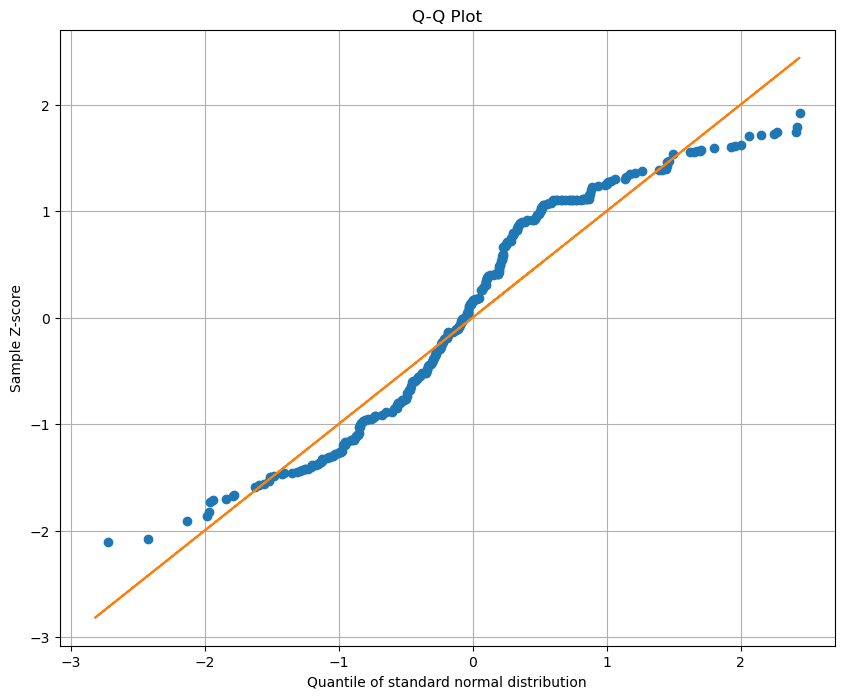

In [5]:
qqplot(stars['1.3441.1031.dat']['mag'])

In [6]:
adfuller = list()
for i in range(len(df['Path'])):
    x = stars[df['Path'][i]]['mag']
    x_is_stationary = perform_test_adfuller(x)
    adfuller.append(x_is_stationary)

In [7]:
is_normal = list()
for i in range(len(df['Path'])):
    x = stars[df['Path'][i]]['mag']
    x_is_normal = jarque_bera(x)
    is_normal.append(x_is_normal)

df['Normality'] = is_normal
df['Non Stationarity'] = adfuller
df[df['Non Stationarity'] == True]

,ID,Class,Path,Band,Normality,Non Stationarity
20,1.3565.579,RRab,1.3565.579.dat,1.0,False,True
56,1.3805.1927,RRab,1.3805.1927.dat,1.0,False,True
137,1.4177.781,RRab,1.4177.781.dat,1.0,False,True
207,1.4537.1521,RRab,1.4537.1521.dat,1.0,False,True
212,1.4540.934,RRab,1.4540.934.dat,1.0,False,True
...,...,...,...,...,...,...
7013,82.8773.1372,RRab,82.8773.1372.dat,1.0,False,True
7035,82.9017.225,RRab,82.9017.225.dat,1.0,False,True
7136,9.4754.816,RRab,9.4754.816.dat,1.0,False,True
7363,9.5486.943,RRab,9.5486.943.dat,1.0,False,True


In [8]:
df[df['Normality'] == True]

,ID,Class,Path,Band,Normality,Non Stationarity


In [21]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

star = '82.9017.225.dat'

X = stars[star]['mjd']
y = stars[star]['mag']

0     -5.143000
1     -5.244382
2     -5.231819
3     -5.300670
4     -5.305686
         ...   
329   -5.260264
330   -5.256254
331   -5.252243
332   -5.243281
333   -5.234000
Name: mag, Length: 334, dtype: float64

In [27]:
p = 2
df_temp = stars[star]

#Generating the lagged p terms
for i in range(1,p+1):
  df_temp['Shifted_values_%d' % i ] = stars[star]['mjd'].shift(i)

train_size = (int)(0.8 * df_temp.shape[0])
print(df_temp)
print(train_size)

              mjd       mag  Shifted_values_1  Shifted_values_2
0    48987.730470 -5.143000               NaN               NaN
1    48995.414592 -5.244382      48987.730470               NaN
2    49003.098713 -5.231819      48995.414592      48987.730470
3    49010.782835 -5.300670      49003.098713      48995.414592
4    49018.466956 -5.305686      49010.782835      49003.098713
..            ...       ...               ...               ...
329  51515.806484 -5.260264      51508.122362      51500.438240
330  51523.490605 -5.256254      51515.806484      51508.122362
331  51531.174727 -5.252243      51523.490605      51515.806484
332  51538.858848 -5.243281      51531.174727      51523.490605
333  51546.542970 -5.234000      51538.858848      51531.174727

[334 rows x 4 columns]
267


In [29]:
#Breaking data set into test and training
df_train = pd.DataFrame(df_temp[0:train_size])
df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

df_train_2 = df_train.dropna()
df_train_2

,mjd,mag,Shifted_values_1,Shifted_values_2
2,49003.098713,-5.231819,48995.414592,48987.730470
3,49010.782835,-5.300670,49003.098713,48995.414592
4,49018.466956,-5.305686,49010.782835,49003.098713
5,49026.151078,-5.300586,49018.466956,49010.782835
6,49033.835200,-5.321285,49026.151078,49018.466956
...,...,...,...,...
262,51000.970335,-5.127250,50993.286213,50985.602092
263,51008.654456,-5.120682,51000.970335,50993.286213
264,51016.338578,-5.114113,51008.654456,51000.970335
265,51024.022700,-5.107545,51016.338578,51008.654456


In [ ]:
#Running linear regression to generate the coefficents of lagged terms
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

theta  = lr.coef_.T
intercept = lr.intercept_
df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
# df_train_2[['Value','Predicted_Values']].plot()

X_test = df_test.iloc[:,1:].values.reshape(-1,p)
df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
# df_test[['Value','Predicted_Values']].plot()

RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

print("The RMSE is :", RMSE,", Value of p : ",p)

In [19]:
from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima.model import ARIMA
import math

tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
param_p = [i for i in range(10)]
param_d = [i for i in range(10)] # el error es cuando d!=0 :o
param_q = [i for i in range(10)]
best_param = dict()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for p in param_p:
        for q in param_q:
            for d in param_d:
                m = ARIMA(q, d, p)
                arima = m.fit(y_train)
                y_pred = m.forecast(y_test, 0)
                rmse.append(math.sqrt(mean_squared_error(y_test, y_pred)))
                # print('ARIMA(' + str(p) + ',' + str(d) + ',' + str(q) + ')')
                # print("RMSE: {}".format(np.mean(rmse)))
                best_param[(p,d,q)] = math.sqrt(mean_squared_error(y_test, y_pred))
                for key, value in best_param.items():
                    if value == min(best_param.values()):
                        min_value = value
                        best_pdq = key
print(min_value)
print(best_pdq)

TypeError: object of type 'NoneType' has no len()

In [14]:
q = best_pdq[0]
d = best_pdq[1]
p = best_pdq[2]

m = ARIMA(q, d, p)
arima = m.fit_predict(y_train)
y_pred = m.forecast(y_test, 0)
df_test = pd.DataFrame({'forecast' : y_pred})
print(y_pred)

[-5.14297869 -5.24352463 -5.22852263 -5.2971096  -5.29932888 -5.29359756
 -5.28699762 -5.26936778 -5.29082782 -5.25582866 -5.3152091  -5.28299128
 -5.27483736 -5.27306121 -5.29629334 -5.30413012 -5.30567267 -5.27411259
 -5.274774   -5.33841108 -5.23476548 -5.29765996 -5.31883865 -5.26248205
 -5.32044522 -5.33638008 -5.27003078 -5.29708308 -5.31234526 -5.27957884
 -5.28855721 -5.29102065 -5.2938356  -5.29492921 -5.29989308 -5.29710383
 -5.30191753 -5.30282564 -5.30638454 -5.31061796 -5.3141387  -5.3179274
 -5.31934725 -5.32234316 -5.3246623  -5.32701714 -5.32945937 -5.33187921
 -5.33430411 -5.3367304  -5.33915669 -5.34158298 -5.30641993 -5.26640978
 -5.31326099 -5.24327225 -5.25520714 -5.24232852 -5.28290291 -5.2551875
 -5.18758744 -5.3053498  -5.22177423 -5.24673715 -5.19618831 -5.26367301]


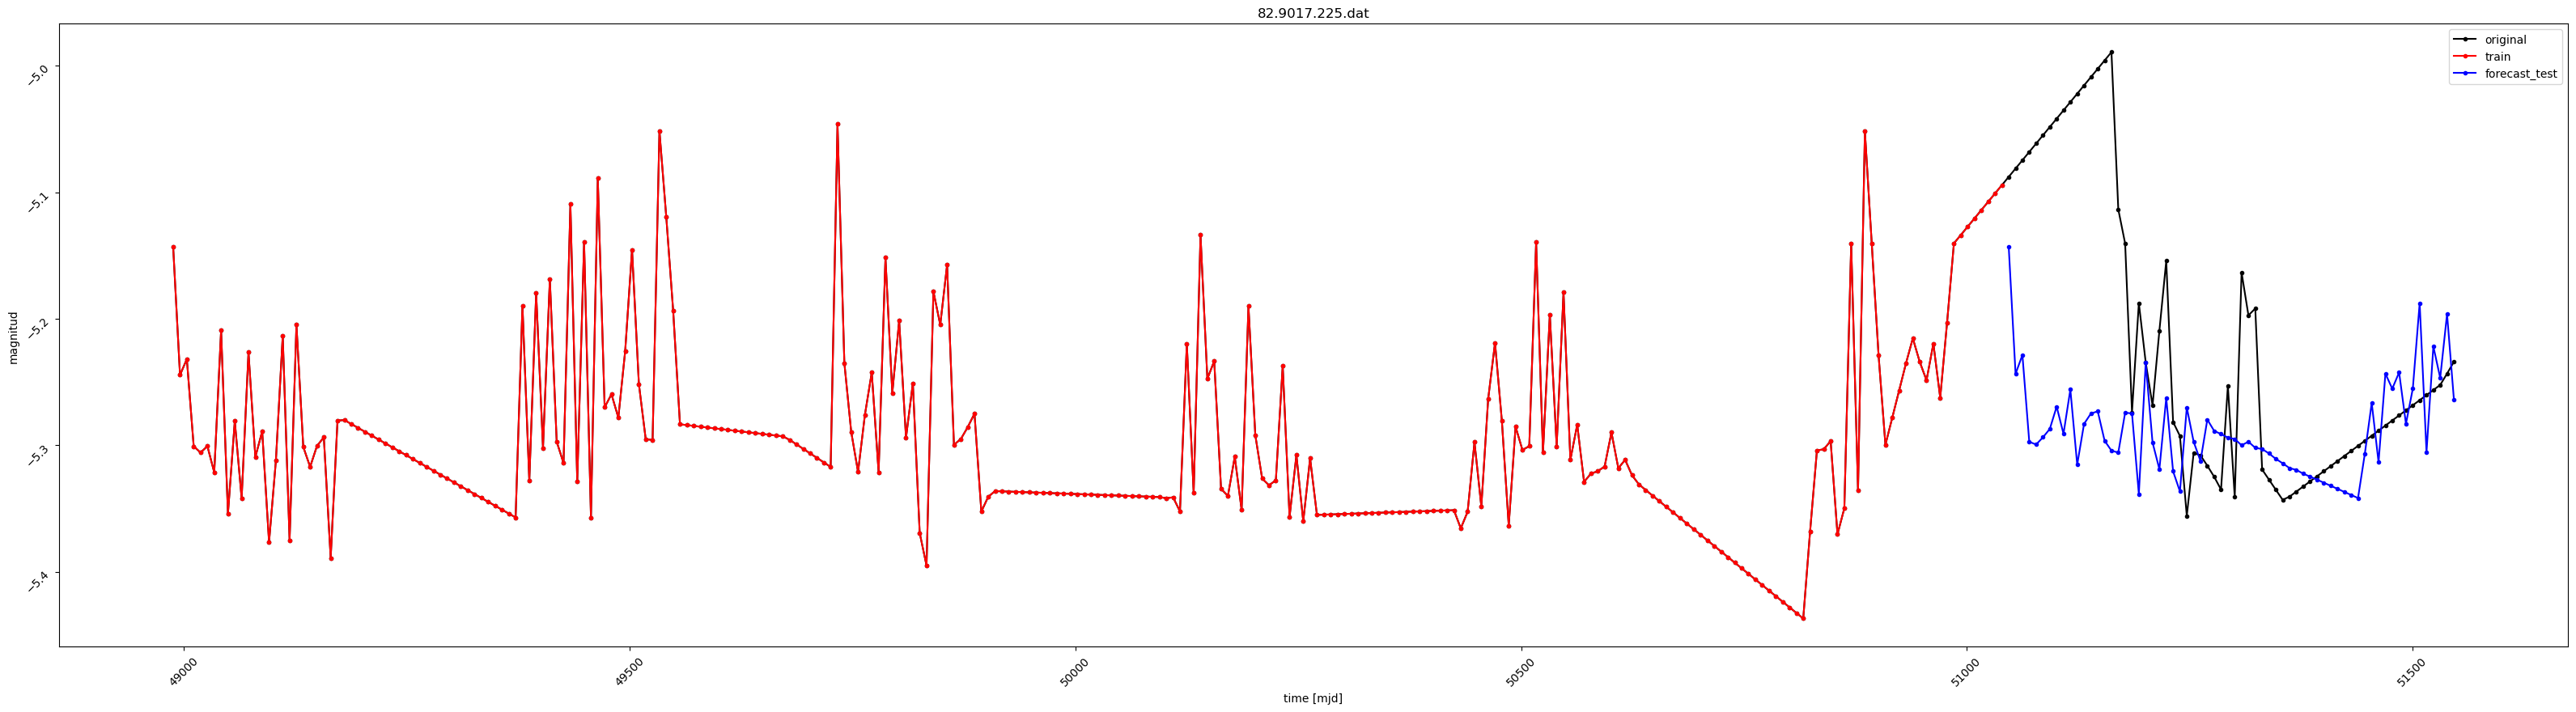

In [15]:
title = star
plt.figure(figsize = (40,10))
plt.plot(X, y, '.-', color = 'black', label = 'original') #.-
plt.plot(X_train, y_train, '.-', color = 'red', label = 'train') #.-
plt.plot(X_test, y_pred, '.-', color = 'blue', label = 'forecast_test') #.-
plt.legend(loc='best')
plt.ylabel('magnitud')
plt.xlabel('time [mjd]')
plt.title(str(title))
plt.tick_params(labelrotation=45)
plt.text.usetex = True
plt.savefig(fname = 'exampleserie.svg')
plt.show()